In [1]:
%matplotlib inline

07. Train YOLOv3 on PASCAL VOC
================================

This tutorial goes through the basic steps of training a YOLOv3 object detection model
provided by GluonCV.

Specifically, we show how to build a state-of-the-art YOLOv3 model by stacking GluonCV components.


.. hint::

    You can skip the rest of this tutorial and start training your YOLOv3 model
    right away by downloading this script:

    :download:`Download train_yolo3.py<../../../scripts/detection/yolo/train_yolo3.py>`
    Random shape training requires more GPU memory but generates better results. You can turn it off by setting `--no-random-shape`.

    Example usage:

    Train a default darknet53 model with Pascal VOC on GPU 0:

    .. code-block:: bash

        python train_yolo3.py --gpus 0

    Train a darknet53 model on GPU 0,1,2,3 with synchronize BatchNorm:

    .. code-block:: bash

        python train_yolo3.py --gpus 0,1,2,3 --network darknet53 --syncbn

    Check the supported arguments:

    .. code-block:: bash

        python train_yolo3.py --help


.. hint::

    Since lots of contents in this tutorial is very similar to :doc:`./train_ssd_voc`, you can skip any part
    if you feel comfortable.




Dataset
-------

Please first go through this `sphx_glr_build_examples_datasets_pascal_voc.py` tutorial to setup Pascal
VOC dataset on your disk.
Then, we are ready to load training and validation images.



In [2]:
import gluoncv as gcv
from gluoncv.data import VOCDetection
root = '../../data/voc/VOCdevkit'
# typically we use 2007+2012 trainval splits for training data
train_dataset = VOCDetection(root, splits=[(2007, 'trainval'), (2012, 'trainval')])
# and use 2007 test as validation data
val_dataset = VOCDetection(root, splits=[(2007, 'test')])
print('Training images:', len(train_dataset))
print('Validation images:', len(val_dataset))

Training images: 16551
Validation images: 4952


Data transform
--------------
We can read an image-label pair from the training dataset:



In [3]:
train_image, train_label = train_dataset[60]
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('image:', train_image.shape)
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

image: (500, 334, 3)
bboxes: (6, 4) class ids: (6, 1)


Plot the image, together with the bounding box labels:



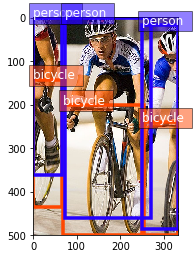

In [4]:
from matplotlib import pyplot as plt
from gluoncv.utils import viz

ax = viz.plot_bbox(train_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

Validation images are quite similar to training because they were
basically split randomly to different sets



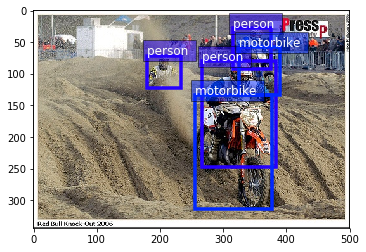

In [5]:
val_image, val_label = val_dataset[100]
bboxes = val_label[:, :4]
cids = val_label[:, 4:5]
ax = viz.plot_bbox(val_image.asnumpy(), bboxes, labels=cids, class_names=train_dataset.classes)
plt.show()

For YOLOv3 networks, we apply similar transforms to SSD example.



In [6]:
from gluoncv.data.transforms import presets
from gluoncv import utils
from mxnet import nd

In [7]:
width, height = 416, 416  # resize image to 416x416 after all data augmentation
train_transform = presets.yolo.YOLO3DefaultTrainTransform(width, height)
val_transform = presets.yolo.YOLO3DefaultValTransform(width, height)

In [8]:
utils.random.seed(123)  # fix seed in this tutorial

apply transforms to train image



In [9]:
train_image2, train_label2 = train_transform(train_image, train_label)
print('tensor shape:', train_image2.shape)

tensor shape: (3, 416, 416)


Images in tensor are distorted because they no longer sit in (0, 255) range.
Let's convert them back so we can see them clearly.



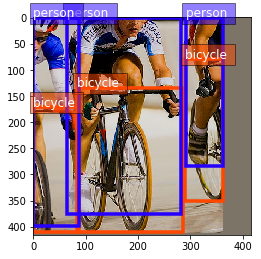

In [10]:
train_image2 = train_image2.transpose((1, 2, 0)) * nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))
train_image2 = (train_image2 * 255).clip(0, 255)
ax = viz.plot_bbox(train_image2.asnumpy(), train_label2[:, :4],
                   labels=train_label2[:, 4:5],
                   class_names=train_dataset.classes)
plt.show()

Transforms used in training include random color distortion, random expand/crop, random flipping,
resizing and fixed color normalization.
In comparison, validation only involves resizing and color normalization.



Data Loader
-----------
We will iterate through the entire dataset many times during training.
Keep in mind that raw images have to be transformed to tensors
(mxnet uses BCHW format) before they are fed into neural networks.

A handy DataLoader would be very convenient for us to apply different transforms and aggregate data into mini-batches.

Because the number of objects varys a lot across images, we also have
varying label sizes. As a result, we need to pad those labels to the same size.
To deal with this problem, GluonCV provides :py:class:`gluoncv.data.batchify.Pad`,
which handles padding automatically.
:py:class:`gluoncv.data.batchify.Stack` in addition, is used to stack NDArrays with consistent shapes.
:py:class:`gluoncv.data.batchify.Tuple` is used to handle different behaviors across multiple outputs from transform functions.



In [11]:
from gluoncv.data.batchify import Tuple, Stack, Pad
from mxnet.gluon.data import DataLoader

batch_size = 2  # for tutorial, we use smaller batch-size
num_workers = 0  # you can make it larger(if your CPU has more cores) to accelerate data loading

# behavior of batchify_fn: stack images, and pad labels
batchify_fn = Tuple(Stack(), Pad(pad_val=-1))
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
val_loader = DataLoader(val_dataset.transform(val_transform), batch_size, shuffle=False,
                        batchify_fn=batchify_fn, last_batch='keep', num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)
    print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape)

data 0: (3, 416, 416) label 0: (3, 6)
data 1: (3, 416, 416) label 1: (3, 6)
data 0: (3, 416, 416) label 0: (2, 6)
data 1: (3, 416, 416) label 1: (2, 6)
data 0: (3, 416, 416) label 0: (5, 6)
data 1: (3, 416, 416) label 1: (5, 6)
data 0: (3, 416, 416) label 0: (12, 6)
data 1: (3, 416, 416) label 1: (12, 6)


YOLOv3 Network
-------------------
GluonCV's YOLOv3 implementation is a composite Gluon HybridBlock.
In terms of structure, YOLOv3 networks are composed of base feature extraction
network, convolutional transition layers, upsampling layers, and specially designed YOLOv3 output layers.

We highly recommend you to read the original paper to learn more about the ideas
behind YOLO [YOLOv3]_.

`Gluon Model Zoo <../../model_zoo/index.html>`__ has a few built-in YOLO networks, more on the way.
You can load your favorite one with one simple line of code:

.. hint::

   To avoid downloading models in this tutorial, we set `pretrained_base=False`,
   in practice we usually want to load pre-trained imagenet models by setting
   `pretrained_base=True`.



In [12]:
from gluoncv import model_zoo
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained_base=False)
print(net)

YOLOV3(
  (_target_generator): YOLOV3TargetMerger(
    (_dynamic_target): YOLOV3DynamicTargetGeneratorSimple(
      (_batch_iou): BBoxBatchIOU(
        (_pre): BBoxSplit(
        
        )
      )
    )
  )
  (_loss): YOLOV3Loss(batch_axis=0, w=None)
  (stages): HybridSequential(
    (0): HybridSequential(
      (0): HybridSequential(
        (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (2): LeakyReLU(0.1)
      )
      (1): HybridSequential(
        (0): Conv2D(None -> 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
        (2): LeakyReLU(0.1)
      )
      (2): DarknetBasicBlockV3(
        (body): HybridSequential(
          (0): HybridSequential(
            (0): Conv2D(None -> 32, kernel

YOLOv3 network is callable with image tensor



In [13]:
import mxnet as mx
x = mx.nd.zeros(shape=(1, 3, 416, 416))
net.initialize()
cids, scores, bboxes = net(x)

YOLOv3 returns three values, where ``cids`` are the class labels,
``scores`` are confidence scores of each prediction,
and ``bboxes`` are absolute coordinates of corresponding bounding boxes.



Training targets
----------------
There are four losses involved in end-to-end YOLOv3 training.
the loss to penalize incorrect class/box prediction, and is defined in :py:class:`gluoncv.loss.YOLOV3Loss`



In [14]:
loss = gcv.loss.YOLOV3Loss()
# which is already included in YOLOv3 network
print(net._loss)

YOLOV3Loss(batch_axis=0, w=None)


To speed up training, we let CPU to pre-compute some training targets (similar to SSD example).
This is especially nice when your CPU is powerful and you can use ``-j num_workers``
to utilize multi-core CPU.



If we provide network to the training transform function, it will compute partial training targets



In [15]:
from mxnet import autograd
train_transform = presets.yolo.YOLO3DefaultTrainTransform(width, height, net)
# return stacked images, center_targets, scale_targets, gradient weights, objectness_targets, class_targets
# additionally, return padded ground truth bboxes, so there are 7 components returned by dataloader
batchify_fn = Tuple(*([Stack() for _ in range(6)] + [Pad(axis=0, pad_val=-1) for _ in range(1)]))
train_loader = DataLoader(train_dataset.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)

for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    print('data:', batch[0][0].shape)
    print('label:', batch[6][0].shape)
    with autograd.record():
        input_order = [0, 6, 1, 2, 3, 4, 5]
        obj_loss, center_loss, scale_loss, cls_loss = net(*[batch[o] for o in input_order])
        # sum up the losses
        # some standard gluon training steps:
        # autograd.backward(sum_loss)
        # trainer.step(batch_size)

data: (3, 416, 416)
label: (4, 4)


This time we can see the data loader is actually returning the training targets for us.
Then it is very naturally a gluon training loop with Trainer and let it update the weights.

.. hint::

  Please checkout the full :download:`training script <../../../scripts/detection/yolo/train_yolo3.py>` for complete implementation.



References
----------

.. [YOLOv3] Redmon, Joseph, and Ali Farhadi. "Yolov3: An incremental improvement." arXiv preprint arXiv:1804.02767 (2018).

